<a href="https://colab.research.google.com/github/aaingyunii/Bootcamp_DeepLearning/blob/main/07_TODO_cifar10_CNN_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# matplotlib 한글 폰트 적용
# 다운로드
## Colab에서 실행
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치 후 런타임 다시시작

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,739 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120509 files and direc

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers


import matplotlib.pyplot as plt
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Colab에서 실행
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 결과 시각화 함수
def plot_result(hist, loss_min=None, loss_max=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(hist.epoch, hist.history['loss'], label='Train Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
    plt.title("Loss")
    if loss_min!=None and loss_max!=None:
        plt.ylim(loss_min, loss_max)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.epoch, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 데이터 로딩

In [3]:
(train_image, train_label), (test_image, test_label) = keras.datasets.cifar10.load_data()

In [4]:
class_names = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭'])

In [5]:
train_image.shape, train_label.shape

((50000, 32, 32, 3), (50000, 1))

In [6]:
np.unique(train_label) # 다중 분류 문제

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# 이미지 확인
- matplotlib을 이용해 N개의 이미지를 확인한다.
    - 개수는 알아서 선택하세요.

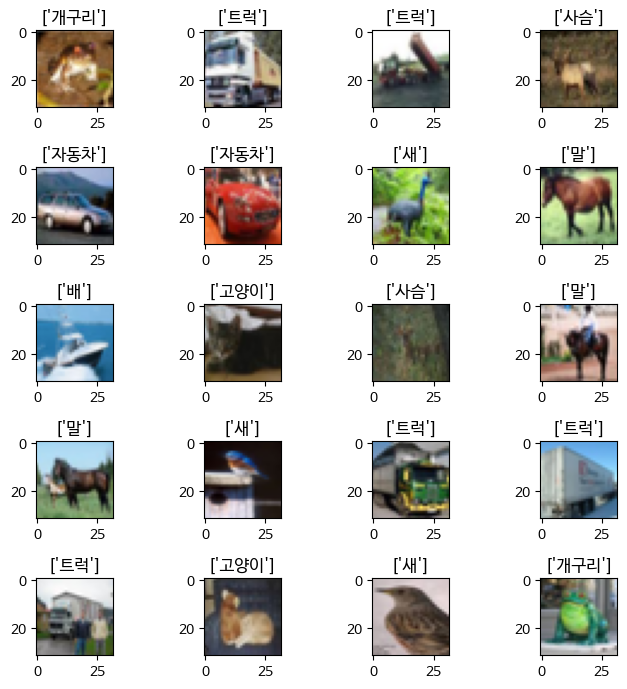

In [7]:
cnt = 20  # 확인할 이미지개수 (5배수)

plt.figure(figsize=(7,7))

for i in range(cnt):
    plt.subplot(5, int(cnt/5), i+1) # 5 줄로 나타낼 것이며, 이에 따라 열의 수를 맞춘다.
    plt.imshow(train_image[i], cmap='Greys')  # gray: 0-black, 255: white,  Greys: 0-white, 255-black
    label = class_names[train_label[i]]
    plt.title(label)

plt.tight_layout()
plt.show()

# 데이터 전처리
- X: 0 ~ 1 scaling
- y: onehot encoding

In [8]:
# y -> Onehot encoding 전처리

y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

print(train_label.shape, y_train.shape)
print(test_label.shape, y_test.shape)

(50000, 1) (50000, 10)
(10000, 1) (10000, 10)


In [9]:
train_image.dtype, train_image.min(), train_image.max()

(dtype('uint8'), 0, 255)

In [10]:
train_image.shape # (데이터 개수, h, w, channel)

(50000, 32, 32, 3)

In [11]:
# X 전처리 -> 0~1 사이 값으로.
X_train = train_image.astype('float32')/255

X_test = test_image.astype('float32')/255

print(X_train.dtype, X_test.dtype)
print(X_train.shape, X_test.shape)


float32 float32
(50000, 32, 32, 3) (10000, 32, 32, 3)


# 하이퍼파라미터, 변수 정의

In [12]:
LEARNING_RATE = 0.001
N_EPOCH = 100 # 100정도로 잡고, EarlydStoppingCallback 을 통해 최고의 성능을 찾으면 끝내는 걸로.
N_BATCH = 1000

N_TRAIN = X_train.shape[0]

# Dataset 생성
- train/test set

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(N_TRAIN)\
                               .batch(N_BATCH, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

# 모델 생성 및 컴파일
- CNN 모델을 이용해 10개의 class를 분류하는 모델을 구현

### 모델의 Convolution layer의 필터 수
- 일반적으로 작은 모델을 사용하거나 필터 개수를 16, 32, 64 등으로 설정하여 시작

In [189]:
def get_cifar10_cnn_model(initial_lr=0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(32, 32, 3))) # 3 => R G B

    # Callback02 : filter 500 추가 및 dropout 0.4 로 변경

    # Callbakc03 - filter 10 30 50 : 이전에는 모델의 너무 복잡해서
                # train만 좋아지고 val에 대해서는 안좋은 것 같아 보였다.
                # Dropout 0.3 으로 조정
                # learning rate decay 추가

    # Callbakc04 - filter 10 30 50 70 100 : 이전 callback03의 학습이 좋았으나
                  # accuracy가 낮아, Feature extraction 과정을 늘림.

    # Callback05 - filter 조정 20 40 80
    #           Dense 128 units만 사용.

    # Callback06 - filter 조정 20 40 80 160
    #           Dense 128 units 2번 반복.
    # model.add(layers.Conv2D(filters=20,
    #                        kernel_size=3,
    #                        padding='same',
    #                        activation='relu'
    #                        ))
    # model.add(layers.MaxPooling2D(padding="same"))
    model.add(layers.Conv2D(filters=10, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=30, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=50, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=70, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=90, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    # model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))

    # model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))

    # model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))
    # model.add(layers.Conv2D(filters=160, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))

    # model.add(layers.Conv2D(filters=240, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))
    # model.add(layers.Conv2D(filters=70, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))

    # model.add(layers.Conv2D(filters=100, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))
    # model.add(layers.Conv2D(filters=400, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))

    # model.add(layers.Conv2D(filters=500, kernel_size=3, padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D(padding='same'))
#-------------------Feature Extractor (Backbone network, Conv base)⬆


#-------------------추론기 ⬇----------------------------
    # Feature map 3차원 -> 1차원 변환, Dense layer 의 입력은 1차원만 가능하므로.
    model.add(layers.Flatten())

    # model.add(layers.Dropout(0.25)) # 과적합, Overfitting 방지
    # model.add(layers.Dropout(0.4))
    model.add(layers.Dropout(0.35))
    # model.add(layers.Dense(units=256, activation='relu'))
    model.add(layers.Dense(units=256))
    model.add(layers.BatchNormalization()) # 평균 : 0+beta,  표준편차 : 1+gamma
    model.add(layers.ReLU())

    model.add(layers.Dense(units=256))
    model.add(layers.BatchNormalization()) # 평균 : 0+beta,  표준편차 : 1+gamma
    model.add(layers.ReLU())

    # model.add(layers.Dropout(0.25)) # 과적합, Overfitting 방지
    # model.add(layers.Dropout(0.4))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(units=128))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Dense(units=128))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    # 출력 Layer
    # model.add(layers.Dropout(0.25))
    # model.add(layers.Dropout(0.4))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))


    # lr_sch = optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_lr,
    #                                                decay_steps=len(train_dataset) * 5,
    #                                                decay_rate=0.5,
    #                                                staircase=True)

    # 컴파일
    model.compile(optimizer=keras.optimizers.Adam(initial_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [190]:
model = get_cifar10_cnn_model(LEARNING_RATE)
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150 (Conv2D)         (None, 32, 32, 10)        280       
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 16, 16, 10)       0         
 ng2D)                                                           
                                                                 
 conv2d_151 (Conv2D)         (None, 16, 16, 30)        2730      
                                                                 
 max_pooling2d_151 (MaxPooli  (None, 8, 8, 30)         0         
 ng2D)                                                           
                                                                 
 conv2d_152 (Conv2D)         (None, 8, 8, 50)          13550     
                                                                 
 max_pooling2d_152 (MaxPooli  (None, 4, 4, 50)       

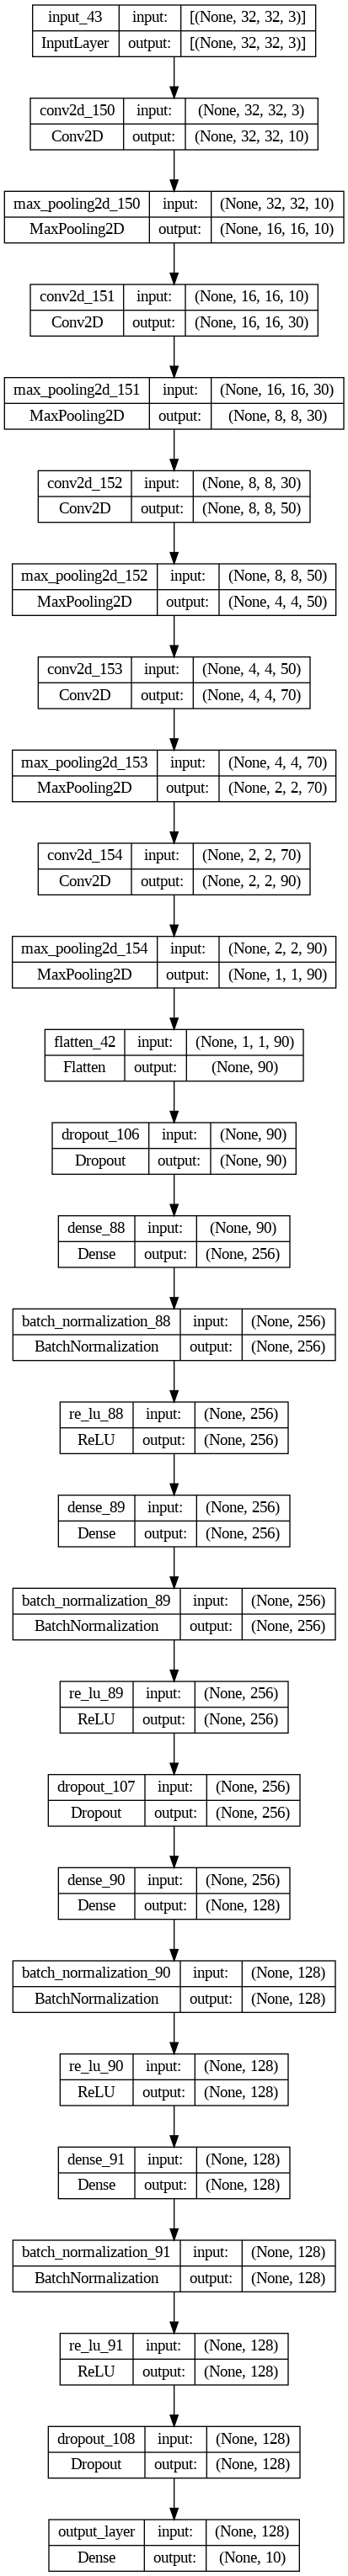

In [191]:
keras.utils.plot_model(model,show_shapes=True, to_file="model_cifar10_10.png")

##### 테스트 학습(epoch 1만 주고)

In [192]:
hist = model.fit(train_dataset,
                 epochs=1,
                 validation_data=test_dataset)

50/50 [==============================] - 7s 28ms/step - loss: 2.3471 - accuracy: 0.1686 - val_loss: 2.2647 - val_accuracy: 0.1093


In [193]:
hist.history

{'loss': [2.347088098526001],
 'accuracy': [0.1685599982738495],
 'val_loss': [2.264735460281372],
 'val_accuracy': [0.10930000245571136]}

# 학습 및 평가
- callback을 이용해 early stopping, 가장 성능 좋았을때 모델 저장 하세요.
    - 모델은 자신의 google drive에 저장하세요.
- 저장됬던 모델을 loading한 뒤 그 모델도 평가해보세요.

### Colab 에서 실행 - GPU를 이용하기위해서.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [194]:
model2 = get_cifar10_cnn_model(LEARNING_RATE)
# model2 = get_cifar10_cnn_model()

In [195]:
# CALLBACK
import os

SAVE_MODEL_PATH = "/content/drive/MyDrive/SAVED_MODELS_TODO"
SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'CIFAR10_CNN_MODEL_CALLBACK_10')

# .ModelCheckpoint() : 학습 도중 한 에폭이 끝나면 모델을 저장
mc_callback = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,
                                              save_best_only=True,
                                              verbose=1
                                              )

# .EarlyStopping() : 조기종료, 성능이 개선되지 않으면 지정한 에폭을 다 하지 않고도 중간에 종료시키는 콜백.
early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    verbose=1
                                                    )

lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.5,
                                                patience=5,
                                                verbose=1
                                                )

hist = model2.fit(train_dataset, epochs=N_EPOCH, validation_data=test_dataset,
                  callbacks=[mc_callback, early_stop_callback, lr_callback])

Epoch 1/100
48/50 [===========================>..] - ETA: 0s - loss: 2.3959 - accuracy: 0.1664
Epoch 1: val_loss improved from inf to 2.30073, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 12s 120ms/step - loss: 2.3821 - accuracy: 0.1686 - val_loss: 2.3007 - val_accuracy: 0.1254 - lr: 0.0010
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 1.8474 - accuracy: 0.2970
Epoch 2: val_loss did not improve from 2.30073
50/50 [==============================] - 1s 27ms/step - loss: 1.8433 - accuracy: 0.2987 - val_loss: 2.3867 - val_accuracy: 0.1009 - lr: 0.0010
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 1.5894 - accuracy: 0.4071
Epoch 3: val_loss did not improve from 2.30073
50/50 [==============================] - 1s 24ms/step - loss: 1.5872 - accuracy: 0.4081 - val_loss: 2.3035 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 4/100
48/50 [===========================>..] - ETA: 0s - loss: 1.4170 - accuracy: 0.4826
Epoch 4: val_loss improved from 2.30073 to 2.12591, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 6s 112ms/step - loss: 1.4161 - accuracy: 0.4830 - val_loss: 2.1259 - val_accuracy: 0.1648 - lr: 0.0010
Epoch 5/100
49/50 [============================>.] - ETA: 0s - loss: 1.3112 - accuracy: 0.5288
Epoch 5: val_loss improved from 2.12591 to 1.93570, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 93ms/step - loss: 1.3082 - accuracy: 0.5300 - val_loss: 1.9357 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 6/100
49/50 [============================>.] - ETA: 0s - loss: 1.2144 - accuracy: 0.5643
Epoch 6: val_loss improved from 1.93570 to 1.85464, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 6s 111ms/step - loss: 1.2136 - accuracy: 0.5649 - val_loss: 1.8546 - val_accuracy: 0.3241 - lr: 0.0010
Epoch 7/100
49/50 [============================>.] - ETA: 0s - loss: 1.1452 - accuracy: 0.5937
Epoch 7: val_loss improved from 1.85464 to 1.73204, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 106ms/step - loss: 1.1457 - accuracy: 0.5935 - val_loss: 1.7320 - val_accuracy: 0.3818 - lr: 0.0010
Epoch 8/100
48/50 [===========================>..] - ETA: 0s - loss: 1.0954 - accuracy: 0.6133
Epoch 8: val_loss improved from 1.73204 to 1.51379, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 6s 130ms/step - loss: 1.0970 - accuracy: 0.6130 - val_loss: 1.5138 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 9/100
49/50 [============================>.] - ETA: 0s - loss: 1.0468 - accuracy: 0.6315
Epoch 9: val_loss improved from 1.51379 to 1.38693, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 95ms/step - loss: 1.0462 - accuracy: 0.6318 - val_loss: 1.3869 - val_accuracy: 0.5164 - lr: 0.0010
Epoch 10/100
50/50 [==============================] - ETA: 0s - loss: 0.9934 - accuracy: 0.6518
Epoch 10: val_loss improved from 1.38693 to 1.23691, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 97ms/step - loss: 0.9934 - accuracy: 0.6518 - val_loss: 1.2369 - val_accuracy: 0.5892 - lr: 0.0010
Epoch 11/100
49/50 [============================>.] - ETA: 0s - loss: 0.9555 - accuracy: 0.6700
Epoch 11: val_loss improved from 1.23691 to 1.11586, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 6s 127ms/step - loss: 0.9557 - accuracy: 0.6701 - val_loss: 1.1159 - val_accuracy: 0.6138 - lr: 0.0010
Epoch 12/100
48/50 [===========================>..] - ETA: 0s - loss: 0.9245 - accuracy: 0.6795
Epoch 12: val_loss did not improve from 1.11586
50/50 [==============================] - 1s 26ms/step - loss: 0.9259 - accuracy: 0.6789 - val_loss: 1.1613 - val_accuracy: 0.5810 - lr: 0.0010
Epoch 13/100
50/50 [==============================] - ETA: 0s - loss: 0.8940 - accuracy: 0.6911
Epoch 13: val_loss improved from 1.11586 to 1.04013, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 7s 131ms/step - loss: 0.8940 - accuracy: 0.6911 - val_loss: 1.0401 - val_accuracy: 0.6371 - lr: 0.0010
Epoch 14/100
50/50 [==============================] - ETA: 0s - loss: 0.8640 - accuracy: 0.7020
Epoch 14: val_loss did not improve from 1.04013
50/50 [==============================] - 1s 25ms/step - loss: 0.8640 - accuracy: 0.7020 - val_loss: 1.0426 - val_accuracy: 0.6382 - lr: 0.0010
Epoch 15/100
48/50 [===========================>..] - ETA: 0s - loss: 0.8314 - accuracy: 0.7131
Epoch 15: val_loss improved from 1.04013 to 1.00265, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 103ms/step - loss: 0.8323 - accuracy: 0.7125 - val_loss: 1.0027 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 16/100
49/50 [============================>.] - ETA: 0s - loss: 0.8029 - accuracy: 0.7246
Epoch 16: val_loss improved from 1.00265 to 1.00018, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 6s 120ms/step - loss: 0.8025 - accuracy: 0.7251 - val_loss: 1.0002 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 17/100
49/50 [============================>.] - ETA: 0s - loss: 0.7825 - accuracy: 0.7328
Epoch 17: val_loss did not improve from 1.00018
50/50 [==============================] - 1s 26ms/step - loss: 0.7837 - accuracy: 0.7325 - val_loss: 1.0214 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 18/100
50/50 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.7420
Epoch 18: val_loss improved from 1.00018 to 0.99170, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 7s 143ms/step - loss: 0.7572 - accuracy: 0.7420 - val_loss: 0.9917 - val_accuracy: 0.6737 - lr: 0.0010
Epoch 19/100
48/50 [===========================>..] - ETA: 0s - loss: 0.7330 - accuracy: 0.7486
Epoch 19: val_loss did not improve from 0.99170
50/50 [==============================] - 1s 26ms/step - loss: 0.7342 - accuracy: 0.7481 - val_loss: 1.0461 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 0.7218 - accuracy: 0.7527
Epoch 20: val_loss improved from 0.99170 to 0.98600, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 108ms/step - loss: 0.7214 - accuracy: 0.7529 - val_loss: 0.9860 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 21/100
48/50 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.7637
Epoch 21: val_loss improved from 0.98600 to 0.97839, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 6s 111ms/step - loss: 0.6951 - accuracy: 0.7634 - val_loss: 0.9784 - val_accuracy: 0.6886 - lr: 0.0010
Epoch 22/100
48/50 [===========================>..] - ETA: 0s - loss: 0.6808 - accuracy: 0.7685
Epoch 22: val_loss did not improve from 0.97839
50/50 [==============================] - 2s 31ms/step - loss: 0.6816 - accuracy: 0.7685 - val_loss: 1.0480 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 23/100
48/50 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.7760
Epoch 23: val_loss improved from 0.97839 to 0.96803, saving model to /content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10


50/50 [==============================] - 5s 103ms/step - loss: 0.6583 - accuracy: 0.7758 - val_loss: 0.9680 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 24/100
50/50 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7773
Epoch 24: val_loss did not improve from 0.96803
50/50 [==============================] - 1s 27ms/step - loss: 0.6499 - accuracy: 0.7773 - val_loss: 1.0207 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 25/100
49/50 [============================>.] - ETA: 0s - loss: 0.6290 - accuracy: 0.7877
Epoch 25: val_loss did not improve from 0.96803
50/50 [==============================] - 1s 24ms/step - loss: 0.6292 - accuracy: 0.7875 - val_loss: 0.9931 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 26/100
49/50 [============================>.] - ETA: 0s - loss: 0.6075 - accuracy: 0.7922
Epoch 26: val_loss did not improve from 0.96803
50/50 [==============================] - 1s 24ms/step - loss: 0.6078 - accuracy: 0.7922 - val_loss: 1.0336 - val_accuracy: 0.6852 - lr: 0.

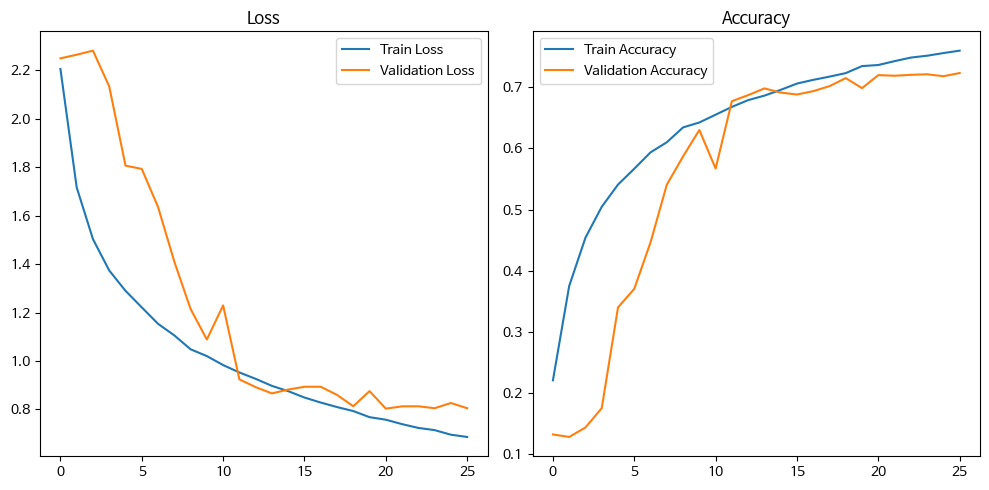

In [187]:
plot_result(hist)

In [188]:
saved_model10 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_10")
saved_model10.evaluate(test_dataset)

10/10 [==============================] - 0s 15ms/step - loss: 0.8035 - accuracy: 0.7197


[0.8034532070159912, 0.7196999788284302]

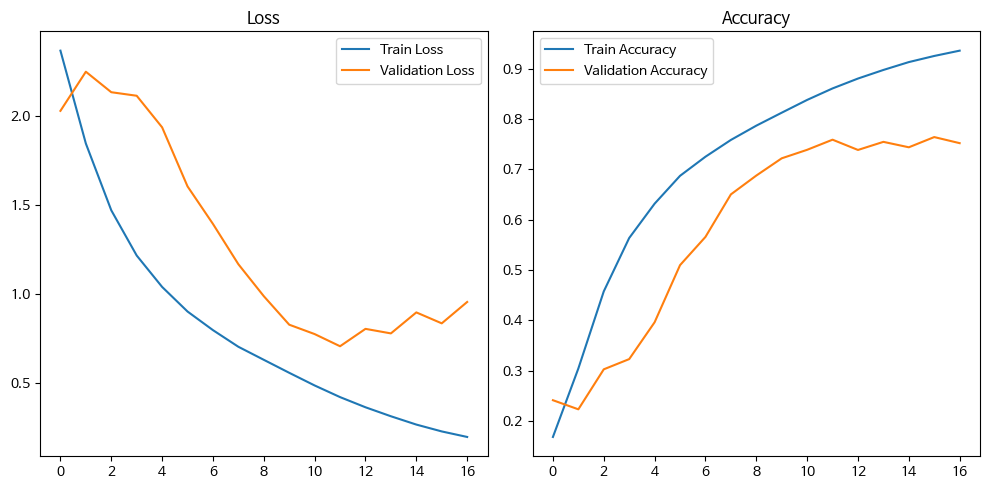

In [33]:
plot_result(hist)
# callback02 - epoch 17 end

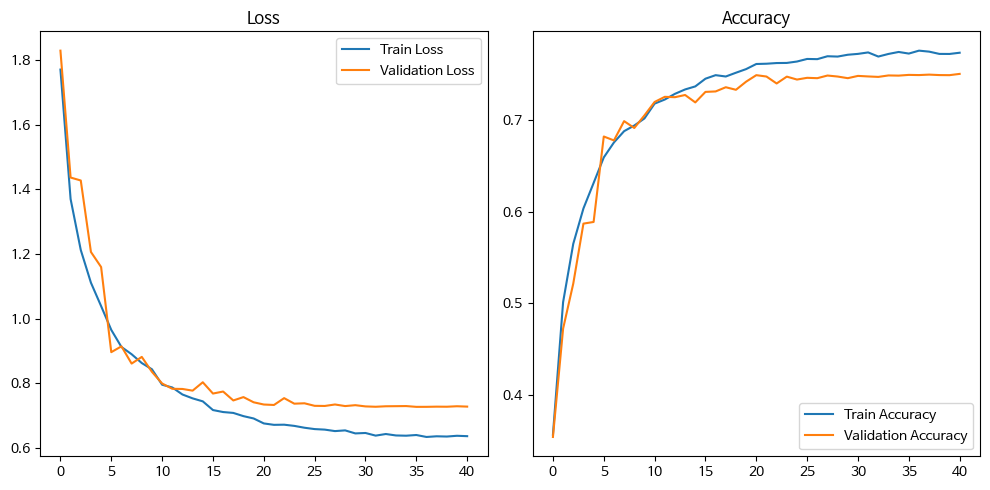

In [59]:
plot_result(hist)
# callback03 - epoch 41 end

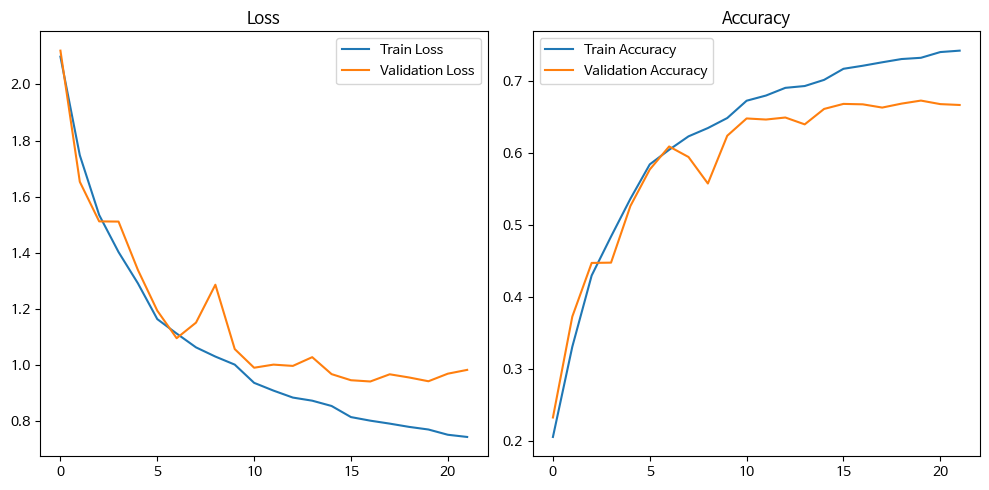

In [68]:
plot_result(hist)
# callback04 - epoch 22 end

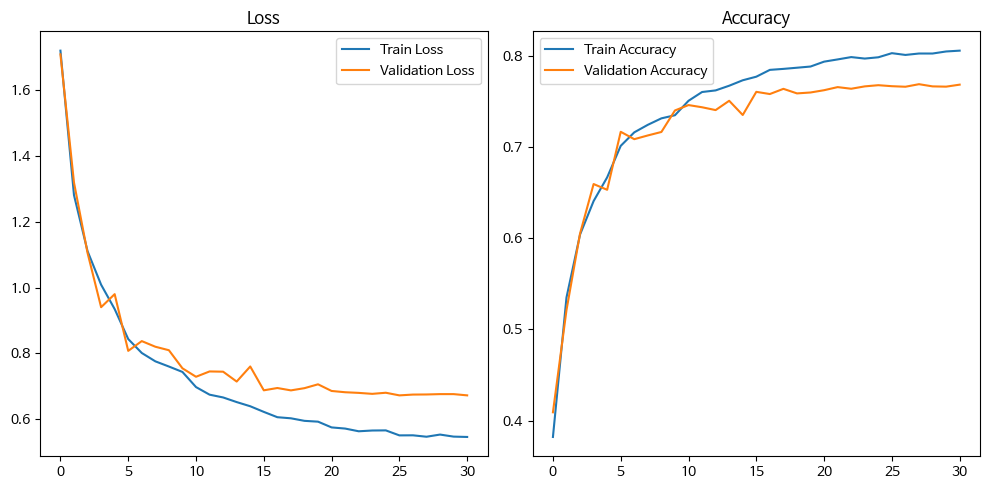

In [77]:
plot_result(hist)
# callback05 - epoch 31 end

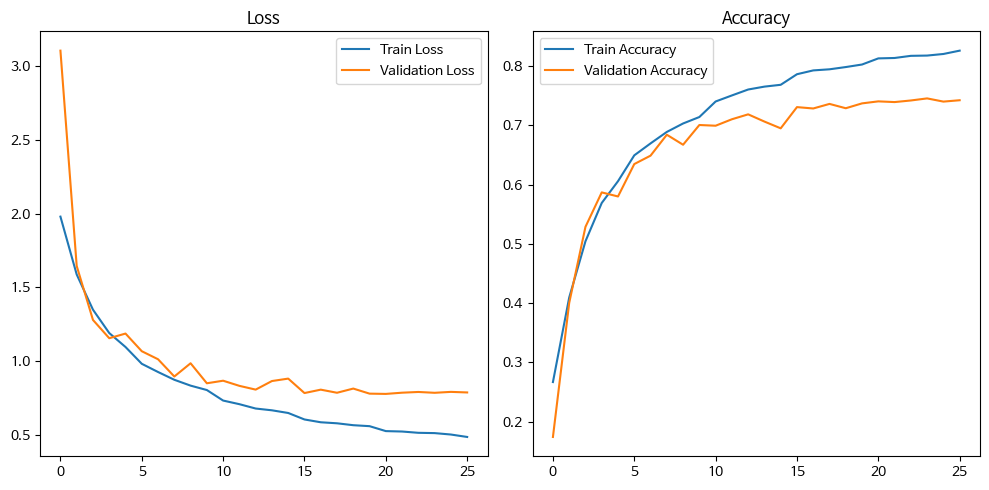

In [88]:
plot_result(hist)
# callback06 - epoch 26 end

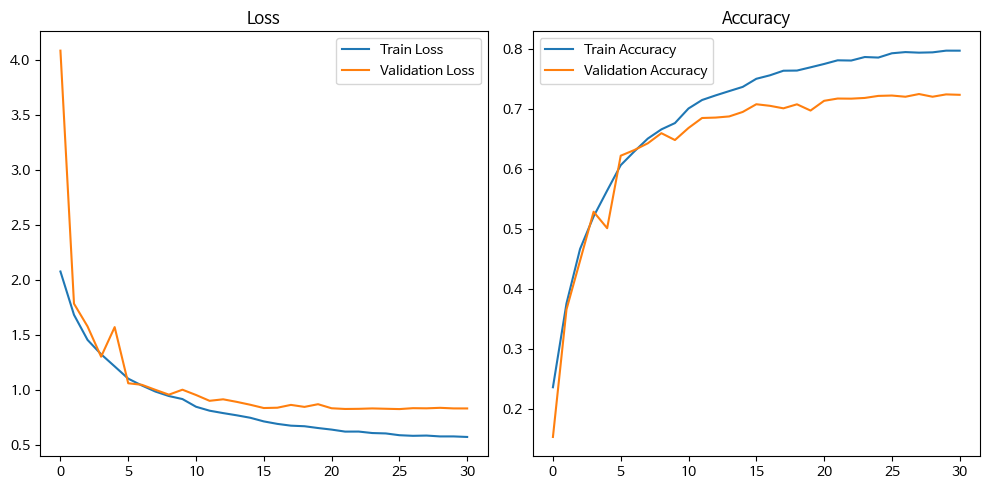

In [95]:
plot_result(hist)
# callback07 - epoch 31 end

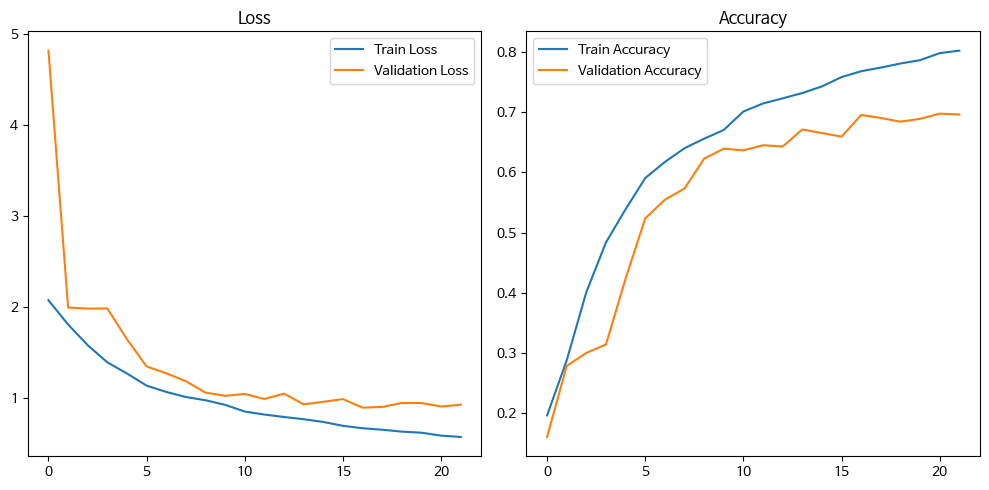

In [102]:
plot_result(hist)
# callback08 - epoch 22 end

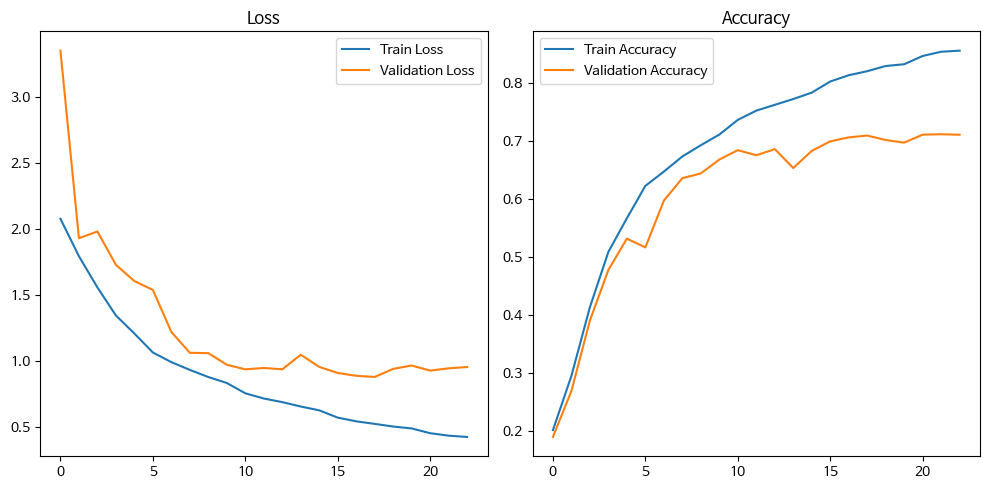

In [111]:
plot_result(hist)
# callback09 - epoch 23 end

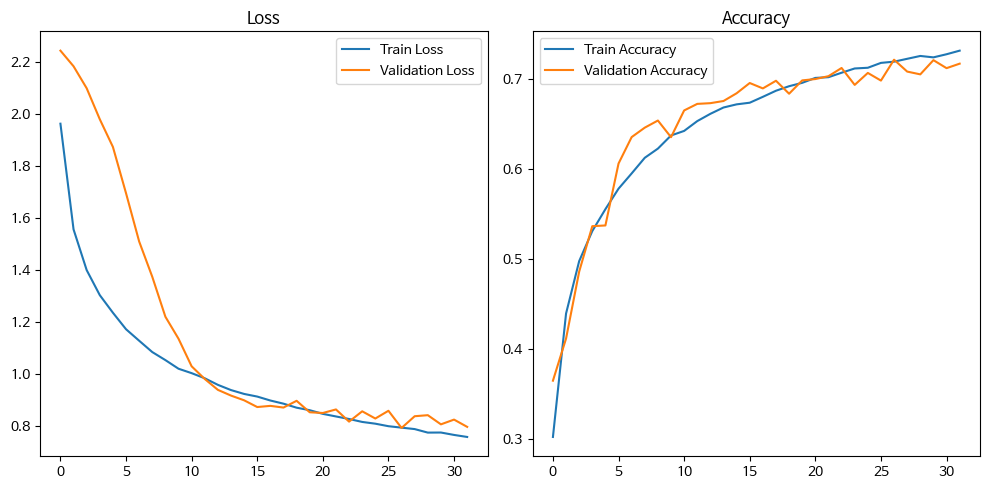

In [159]:
plot_result(hist)
# callback10 - epoch 44 end

In [25]:
saved_model01 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_01")
saved_model01.evaluate(test_dataset)

10/10 [==============================] - 1s 44ms/step - loss: 0.6347 - accuracy: 0.7855


[0.6346612572669983, 0.7854999899864197]

In [45]:
saved_model02 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_02")
saved_model02.evaluate(test_dataset)

10/10 [==============================] - 1s 50ms/step - loss: 0.7060 - accuracy: 0.7588


[0.7060157060623169, 0.7588000297546387]

In [60]:
saved_model03 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_03")
saved_model03.evaluate(test_dataset)

10/10 [==============================] - 0s 13ms/step - loss: 0.7269 - accuracy: 0.7497


[0.7269379496574402, 0.7497000098228455]

In [69]:
saved_model04 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_04")
saved_model04.evaluate(test_dataset)

10/10 [==============================] - 0s 12ms/step - loss: 0.9420 - accuracy: 0.6674


[0.941994845867157, 0.6674000024795532]

In [78]:
saved_model05 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_05")
saved_model05.evaluate(test_dataset)

10/10 [==============================] - 0s 14ms/step - loss: 0.6726 - accuracy: 0.7666


[0.6726399660110474, 0.7666000127792358]

In [89]:
saved_model06 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_06")
saved_model06.evaluate(test_dataset)

10/10 [==============================] - 0s 16ms/step - loss: 0.7783 - accuracy: 0.7404


[0.7783020734786987, 0.7404000163078308]

In [96]:
saved_model07 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_07")
saved_model07.evaluate(test_dataset)

10/10 [==============================] - 1s 19ms/step - loss: 0.8260 - accuracy: 0.7225


[0.825960636138916, 0.7225000262260437]

In [103]:
saved_model08 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_08")
saved_model08.evaluate(test_dataset)

10/10 [==============================] - 0s 18ms/step - loss: 0.8948 - accuracy: 0.6955


[0.8948432803153992, 0.6955000162124634]

In [112]:
saved_model09 = models.load_model("/content/drive/MyDrive/SAVED_MODELS_TODO/CIFAR10_CNN_MODEL_CALLBACK_09")
saved_model09.evaluate(test_dataset)

10/10 [==============================] - 0s 19ms/step - loss: 0.8791 - accuracy: 0.7097


[0.87905353307724, 0.7096999883651733]